<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.Auto Encoder

AutoEncoder generally performs learning to minimize mean squared errors between input and output.

Thus, the output of the AutoEncoder is the same as the input.

The features of the hidden layer are applied to various tasks.

※If you want to perform learning, create a source file.

Import of required library.

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from skimage import io

Fixed seed value for random numbers.

In [58]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Parameter definition.

In [59]:
BATCH_SIZE      = 1000
WEIGHT_DECAY    = 0.001
LEARNING_RATE   = 0.01
EPOCH           = 500
NUM_WORKERS     = 2

Reading dataset.

In [60]:
mnist_train = dsets.MNIST(".", download=True, train=True)
dataTrain = []
dataTest = []


mnist_test = dsets.MNIST(".", download=True, train=False)



for i in range(len(mnist_train)):
    dataTrain.append(np.array(mnist_train[i][0]))


for i in range(len(mnist_test)):
    dataTest.append(np.array(mnist_test[i][0]))

#Change shape to (N, C, H, W) by reshape.
dataTrain = np.array(dataTrain)
dataTrain = dataTrain.reshape(len(mnist_train), 1, 28, 28)
dataTrain = dataTrain / 255.0

dataTest = np.array(dataTest)
dataTest = dataTest.reshape(len(mnist_test), 1, 28, 28)
dataTest = dataTest / 255.0

datasizeTrain = len(dataTrain)
datasizeTest  = len(dataTest)

Define the model structure.

In this example, a multi-layer perceptron having 10 units in hidden layer is used.

In [61]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(28*28*1, 10)
        self.fc2 = nn.Linear(10, 28*28*1)

    def forward(self, x):
        x = x.view(-1, 28*28*1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(BATCH_SIZE, 1, 28, 28)
        return x
      

net = Network()
if torch.cuda.is_available():
    net.cuda()

Define loss and optimizer.

In [62]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

Input data into the model for each mini-batch and perform parameter update.

In [63]:
trainLoss = []
testLoss  = []


for epoch in range(1, EPOCH+1):
    if (epoch % 10 == 0):
        print("epoch", epoch, "iter", epoch*(datasizeTrain//BATCH_SIZE))

    net.train()
    for i in range(0, datasizeTrain, BATCH_SIZE):
        perm = np.random.permutation(datasizeTrain)
        xBatch = dataTrain[perm[i:i+BATCH_SIZE]]
        tBatch = dataTrain[perm[i:i+BATCH_SIZE]]
        xBatch = torch.from_numpy(xBatch.copy()).float()
        tBatch = torch.from_numpy(tBatch.copy()).float()
        if torch.cuda.is_available():
            xBatch.cuda()
            tBatch.cuda()
        optimizer.zero_grad()
        yBatch = net(xBatch)
        loss = criterion(yBatch, tBatch)
        loss.backward()
        optimizer.step()

    net.eval()
    sumTrainLoss = 0.0
    with torch.no_grad():
        for i in range(0, datasizeTrain, BATCH_SIZE):
            perm = np.random.permutation(datasizeTrain)
            xBatch = dataTrain[perm[i:i+BATCH_SIZE]]
            tBatch = dataTrain[perm[i:i+BATCH_SIZE]]
            xBatch = torch.from_numpy(xBatch.copy()).float()
            tBatch = torch.from_numpy(tBatch.copy()).float()
            if torch.cuda.is_available():
                xBatch.cuda()
                tBatch.cuda()
            yBatch = net(xBatch)
            loss = criterion(yBatch, tBatch)
            sumTrainLoss += float(loss.cpu().data.item()) * BATCH_SIZE
        trainLoss.append(sumTrainLoss / datasizeTrain)

        sumTestLoss = 0.0
        for i in range(0, datasizeTest, BATCH_SIZE):
            perm = np.random.permutation(datasizeTest)
            xBatch = dataTest[perm[i:i+BATCH_SIZE]] # (BATCH_SIZE, 1, 128, 128)
            tBatch = dataTest[perm[i:i+BATCH_SIZE]] # (BATCH_SIZE, 1, 128, 128)
            xBatch = torch.from_numpy(xBatch.copy()).float()
            tBatch = torch.from_numpy(tBatch.copy()).float()
            if torch.cuda.is_available():
                xBatch.cuda()
                tBatch.cuda()
            yBatch = net(xBatch)
            loss = criterion(yBatch, tBatch)
            sumTestLoss += float(loss.cpu().data.item()) * BATCH_SIZE
        testLoss.append(sumTestLoss / datasizeTest)

    if (epoch % 10 == 0):
        print("\ttrain mean loss={}".format(sumTrainLoss / datasizeTrain))
        print("\ttest  mean loss={}".format(sumTestLoss / datasizeTest))

epoch 10 iter 600
	train mean loss=0.12878508220116297
	test  mean loss=0.13053371012210846
epoch 20 iter 1200
	train mean loss=0.11127943682173888
	test  mean loss=0.1127384327352047
epoch 30 iter 1800
	train mean loss=0.09913430536786715
	test  mean loss=0.09996178597211838
epoch 40 iter 2400
	train mean loss=0.09100556795795758
	test  mean loss=0.09244673997163773
epoch 50 iter 3000
	train mean loss=0.08526805328826109
	test  mean loss=0.08687684088945388
epoch 60 iter 3600
	train mean loss=0.08139122414092223
	test  mean loss=0.08223465904593467
epoch 70 iter 4200
	train mean loss=0.0785021111369133
	test  mean loss=0.07903124913573265
epoch 80 iter 4800
	train mean loss=0.07648219838738442
	test  mean loss=0.0774450421333313
epoch 90 iter 5400
	train mean loss=0.07490664298335711
	test  mean loss=0.07544931992888451
epoch 100 iter 6000
	train mean loss=0.07385997797052066
	test  mean loss=0.07424059063196183
epoch 110 iter 6600
	train mean loss=0.07291118564705054
	test  mean loss

Draw the graph of training curve of loss

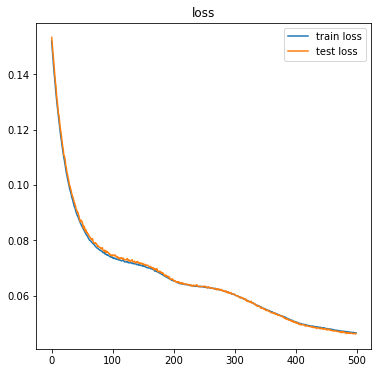

In [64]:
plt.figure(figsize=(6,6))

plt.plot(range(EPOCH), trainLoss)
plt.plot(range(EPOCH), testLoss)
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss.png")

Plot the some output result of the network as an image.

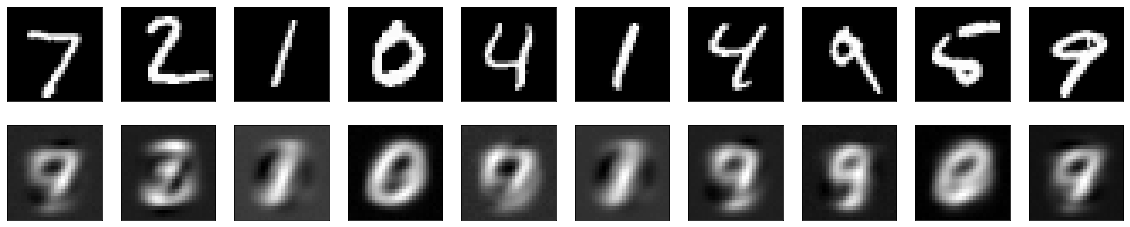

In [65]:
result = np.zeros((datasizeTrain, 1, 28, 28))
result_test = np.zeros((datasizeTest, 1, 28, 28))

#Get network output for train data.
for i in range(0, datasizeTrain, BATCH_SIZE):
    xBatch = dataTrain[i:i+BATCH_SIZE]
    xBatch = torch.from_numpy(xBatch.copy()).float()
#    if torch.cuda.is_available():
#        xBatch.cuda
    re = net(xBatch)
    if torch.cuda.is_available():
        re.cpu()
    result[i:i+BATCH_SIZE] = re.data

#Get network output for test data.
for i in range(0, datasizeTest, BATCH_SIZE):
    xBatch = dataTest[i:i+BATCH_SIZE]
    xBatch = torch.from_numpy(xBatch.copy()).float()
#    if torch.cuda.is_available():
#        xBatch.cuda()
    re = net(xBatch)

    if torch.cuda.is_available():
        re.cpu()
    result_test[i:i+BATCH_SIZE] = re.data

  
#Save the image.
#for i in range(datasizeTrain):
#	pic = result[i]
#	pic= pic.reshape((28,28))
#	io.imsave("./imgtrain%d.png"%i, pic)


#for i in range(datasizeTest):
#	pic = result_test[i]
#	pic= pic.reshape((28,28))
#	io.imsave("./imgtest%d.png"%i, pic)


# display the images
#%matplotlib inline
#import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(dataTest[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(result_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()